## Libraries & necessary pre-code

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

## Data Collection

In [2]:
tickers = ['TSM', 'NVDA', 'AMD', 'INTC', 'ORCL']
start_date = '2024-10-23'
end_date = '2025-10-23'

def get_ticker_data(ticker, start_date, end_date):
    '''
    Collects daily data for a tickers and returns a dataframe of
    it (without multilevel columns)

    :param ticker: String of a ticker (ex: '^GSPC')
    :param: start_date: start date String in format 'YYYY-MM-DD'
    :param: end_date: end date String in format 'YYYY-MM-DD'

    :return: df (pd.Dataframe) of the data for that ticker on YTD data
    '''
    try:
        # Only really need Open & Close to get daily_returns, and don't need Ticker in the data (drop it)
        data = yf.download(ticker, start=start_date, end=end_date, progress=False)[['Open', 'Close']].droplevel(1, axis=1)
    except Exception:
        return f"Data collection failed for {ticker} from {start_date} to {end_date}"

    return data

# Test
# print(get_ticker_data('^GSPC', '2025-01-06', '2025-10-22').droplevel(1, axis=1))

def get_tickers_data(tickers, start_date, end_date):
    '''
    Iterates through a list of tickers and returns a dictionary of dataframes for it.

    :param tickers: list of Strings of tickers ex: '^GSPC', 'TSMC'
    :param: start_date: start date String in format 'YYYY-MM-DD'
    :param: end_date: end date String in format 'YYYY-MM-DD'

    :return: dictionary of DataFrames connected to the ticker
    '''
    ticker_dict = {}
    try:
        for ticker in tickers:
            ticker_dict[ticker] = get_ticker_data(ticker, start_date, end_date)
    except Exception:
        return f"Data collection failed for {tickers} from {start_date} to {end_date}"

    return ticker_dict

data_dict = get_tickers_data(tickers, start_date, end_date)

rolling_start_date =  '2024-8-08'
# start atleast 50d  back

rolling_data_dict = get_tickers_data(tickers, rolling_start_date, end_date)

# Save to csv
for ticker in data_dict:
    data_dict[ticker].to_csv(f'{ticker}_data.csv')

# Test
data_dict

{'TSM': Price             Open       Close
 Date                              
 2024-10-23  193.973057  198.095535
 2024-10-24  196.221694  195.205856
 2024-10-25  197.493932  200.640030
 2024-10-28  196.517546  192.000580
 2024-10-29  191.714585  194.229492
 ...                ...         ...
 2025-10-16  310.929993  299.839996
 2025-10-17  298.399994  295.079987
 2025-10-20  300.000000  297.700012
 2025-10-21  299.000000  294.510010
 2025-10-22  293.000000  288.880005
 
 [250 rows x 2 columns],
 'NVDA': Price             Open       Close
 Date                              
 2024-10-23  141.989282  139.519989
 2024-10-24  140.779637  140.369751
 2024-10-25  140.889594  141.499420
 2024-10-28  142.959021  140.479736
 2024-10-29  140.249772  141.209503
 ...                ...         ...
 2025-10-16  182.229996  181.809998
 2025-10-17  180.179993  183.220001
 2025-10-20  183.130005  182.639999
 2025-10-21  182.789993  181.160004
 2025-10-22  181.139999  180.279999
 
 [250 rows x 2 colum

## Data Cleaning

In [3]:
# Here we want to clean the data so drop the multilevel columns, verify data, ensure no missing data

# First, check data (see if any missing)
# I think this is the only check we need as yFinance has consistent dating data, naming, pricing (don't have to worry about type mismatch or other trivial items)
def handle_nan(ticker_df):
    '''
    Checks whether the number of missing values is > 0, and if so then use dropna() to clean

    :param ticker_df: the ticker's Data in a pd.DataFrame
    :return: the corrected (or unmodified) dataframe
    '''
    # If >, there's missing
    if ticker_df.isnull().sum().any():
        print(f"Missing vals: {ticker_df.isnull().sum().all()}")
        ticker_df = ticker_df.dropna()

    return ticker_df

# Run it for all our stocks
for ticker in data_dict:
    data_dict[ticker] = handle_nan(data_dict[ticker])
    # Didn't print, so that mean's there's no NaNs

## Feature Engineering


In [4]:
# Daily returns
def get_daily_returns(ticker_data):
    '''
    Get daily returns (% delta) for a ticker (given data) Use ticker data including 1d before start date.

    :param ticker_data: Should be a dataframe including the open and close prices for a certajn amount o dates
    :return: a series of returns or an exception if can't parse data
    '''

    try:
        returns = (ticker_data['Close'].pct_change())
    except Exception:
        return "Data has no Close."
    return returns

# Log returns
def get_log_returns(ticker_data):
    '''
    Get daily log returns for a ticker (given data)

    :param ticker_data: Should be a dataframe including the open and close prices for a certajn amount o dates
    :return: a series of log returns or an exception if can't parse data
    '''

    try:
        log_returns = np.log(ticker_data['Close'] / ticker_data['Open'])


    except Exception:
        return "Issue parsing Open/Close data."

    return log_returns

# Rolling vol
def get_rolling_volatility(ticker_data, window_size=30):
    '''
    Get rolling volatility for a ticker (given data).
    We will use a 30d time period rolling. Use ticker data including 30d before start date.

    :param ticker_data: Should be a dataframe including the open and close prices for a certajn amount o dates
    :return: a series of rolling volatilities based on dates or exception if can't parse
    '''
    try:
        returns = get_daily_returns(ticker_data)
        rolling_vol = returns.rolling(window=window_size).std()
    except Exception:
        return "issue parsing data."

    return rolling_vol

# SMAs
def get_sma(ticker_data, window_size=50):
    '''
    Get simple moving average for a ticker (given data).
    Default is 50 day SMA

    :param ticker_data: df with Close prices
    :param window_size: rolling window size (default 50)
    :return: series of SMA values or exception if can't parse
    '''
    try:
        sma = ticker_data['Close'].rolling(window=window_size).mean()
    except Exception:
        return "Issue parsing Close data."

    return sma

# RSIs

def get_rsi(ticker_data, window_size=14):
    '''
    Get Relative Strength Index (RSI) for a ticker (given data).
    Default window period is 14 days.

    :param ticker_data: df with Close prices
    :param window_size: rolling window size (default 14)
    :return: series of RSI values or exception if can't parse
    '''
    try:
        # price change
        delta = ticker_data['Close'].diff()

        gains = delta.where(delta > 0, 0)
        losses = -delta.where(delta < 0, 0)

        # Calculate the initial average gain and loss (simple average for first period)
        avg_gain = gains.rolling(window=window_size, min_periods=window_size).mean()
        avg_loss = losses.rolling(window=window_size, min_periods=window_size).mean()

        # averaging
        for i in range(window_size, len(ticker_data)):
            avg_gain.iloc[i] = (avg_gain.iloc[i-1] * (window_size - 1) + gains.iloc[i]) / window_size
            avg_loss.iloc[i] = (avg_loss.iloc[i-1] * (window_size - 1) + losses.iloc[i]) / window_size

        # rel strength
        rs = avg_gain / avg_loss

        # RSI
        rsi = 100 - (100 / (1 + rs))

        return rsi

    except Exception:
        return "Issue parsing Close data or accessing Dataframe; or . Make sure input is correct."

# Now, combine into the existing dataframes
for ticker in rolling_data_dict:
    df_with_buffer = rolling_data_dict[ticker]

    # Get + slice
    daily_returns = get_daily_returns(df_with_buffer).loc['2024-10-23':]
    log_returns = get_log_returns(df_with_buffer).loc['2024-10-23':]
    rolling_vol = get_rolling_volatility(df_with_buffer, window_size=30).loc['2024-10-23':]
    twenty_day_sma = get_sma(df_with_buffer,20).loc['2024-10-23':]
    fifty_day_sma = get_sma(df_with_buffer).loc['2024-10-23':]
    rsi = get_rsi(df_with_buffer).loc['2024-10-23':]

    # put into existing
    data_dict[ticker]['Daily_Return'] = daily_returns
    data_dict[ticker]['Log_Return'] = log_returns
    data_dict[ticker]['Rolling_Vol'] = rolling_vol
    data_dict[ticker]['20_Day_SMA'] = twenty_day_sma
    data_dict[ticker]['50_Day_SMA'] = fifty_day_sma
    data_dict[ticker]['RSI'] = rsi




# Test
data_dict['AMD']


Price,Open,Close,Daily_Return,Log_Return,Rolling_Vol,20_Day_SMA,50_Day_SMA,RSI
Date,,,,,,,,
2024-10-23,153.000000,152.910004,-0.007658,-0.000588,0.023138,162.561001,154.6292,43.093144
2024-10-24,154.740005,153.440002,0.003466,-0.008437,0.023123,161.858501,154.8830,43.918516
2024-10-25,155.399994,156.229996,0.018183,0.005327,0.023280,161.452500,155.0604,48.179406
2024-10-28,158.500000,159.919998,0.023619,0.008919,0.023632,161.244500,155.2876,53.239600
2024-10-29,161.100006,166.250000,0.039582,0.031467,0.024516,161.569500,155.5070,60.385834
...,...,...,...,...,...,...,...,...
2025-10-16,236.289993,234.559998,-0.016932,-0.007348,0.055759,189.374499,174.9506,72.596805
2025-10-17,233.259995,233.080002,-0.006310,-0.000772,0.053853,193.158999,176.1642,71.467219
2025-10-20,236.470001,240.559998,0.032092,0.017148,0.053865,197.197499,177.5202,73.694968


## Exploratory Analysis

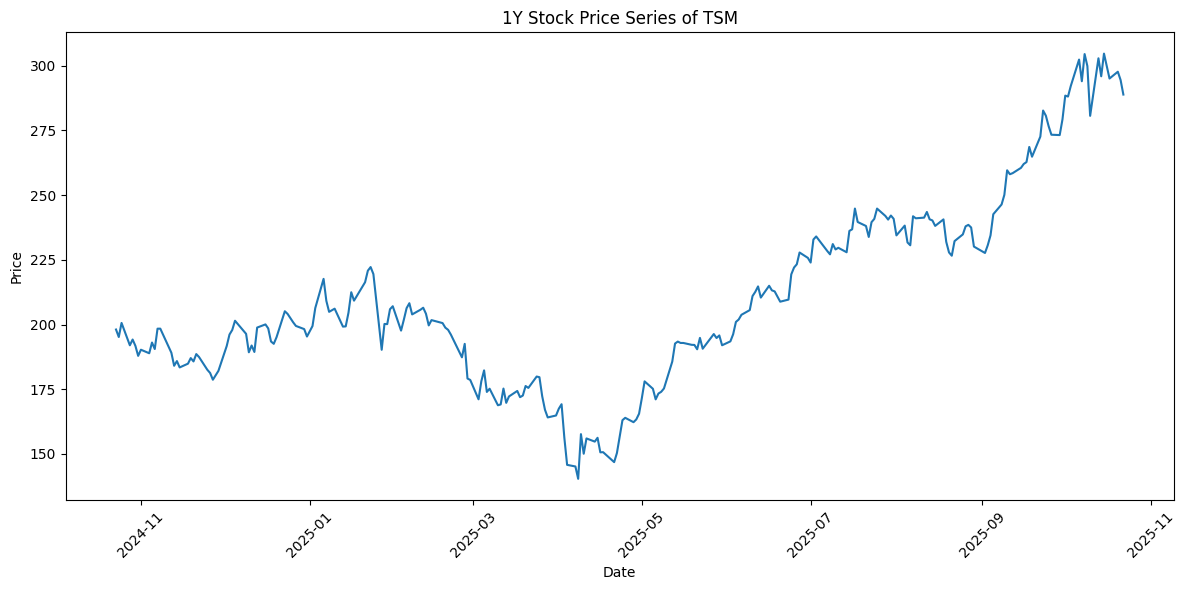

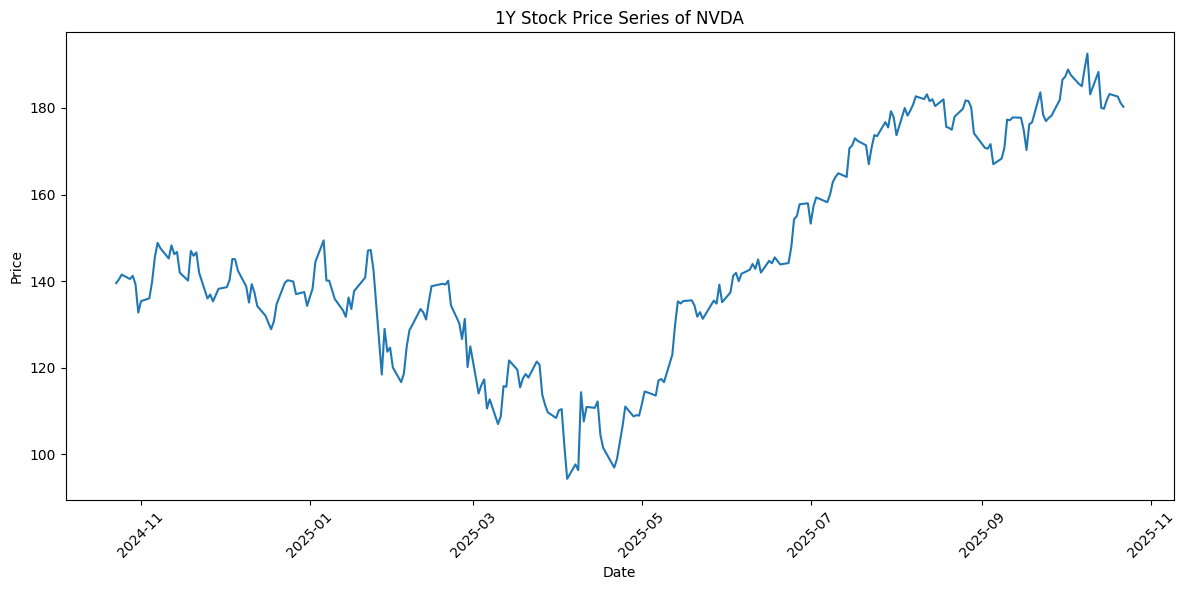

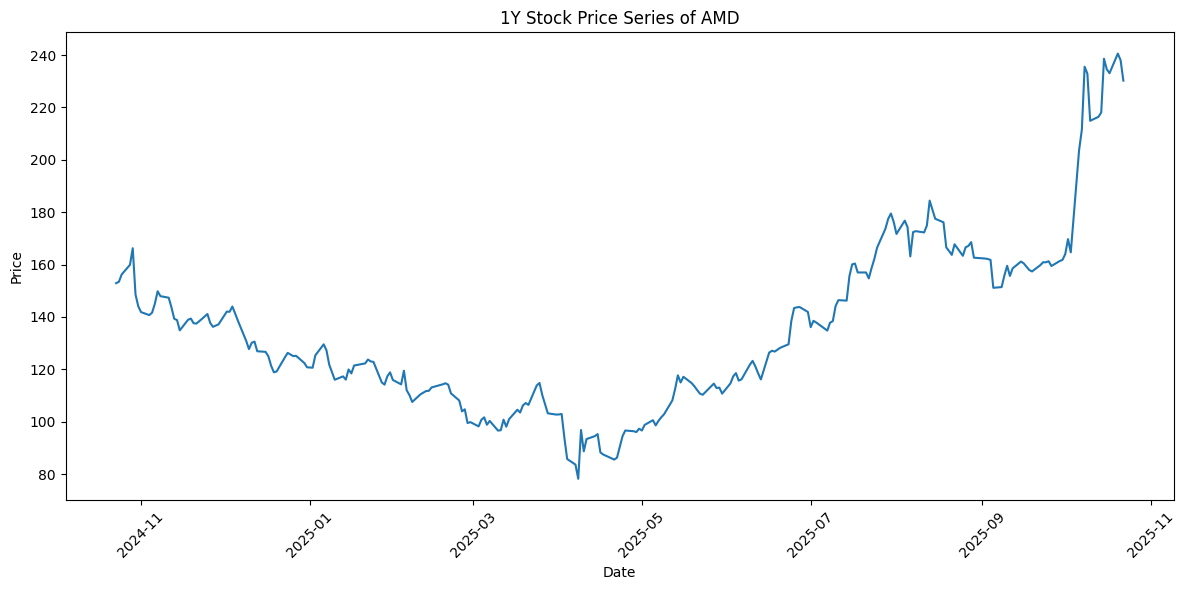

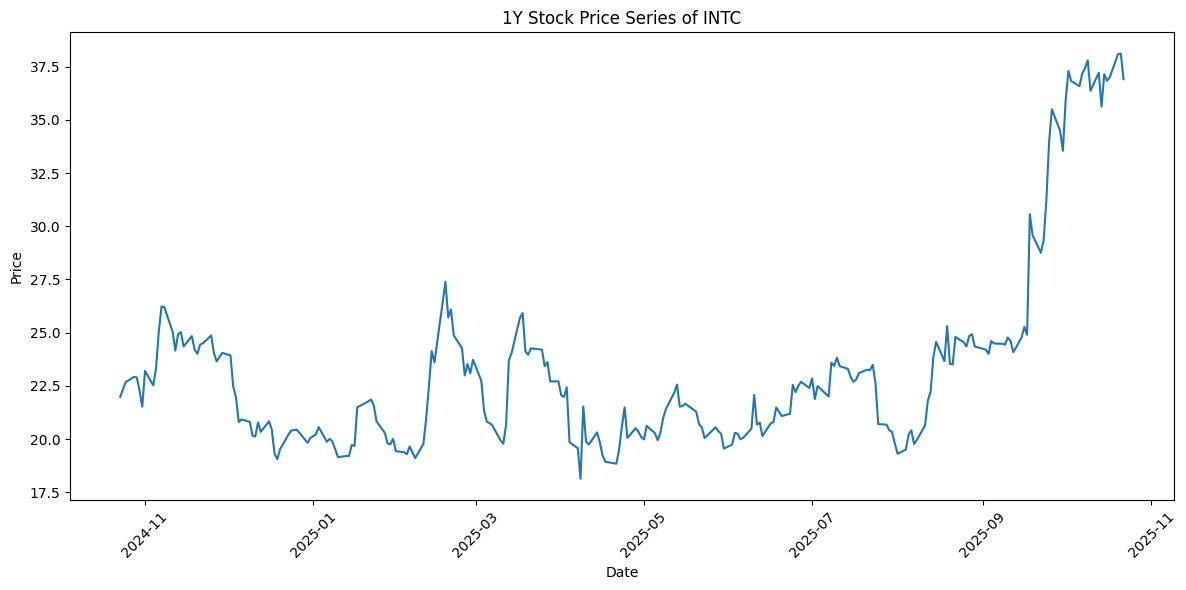

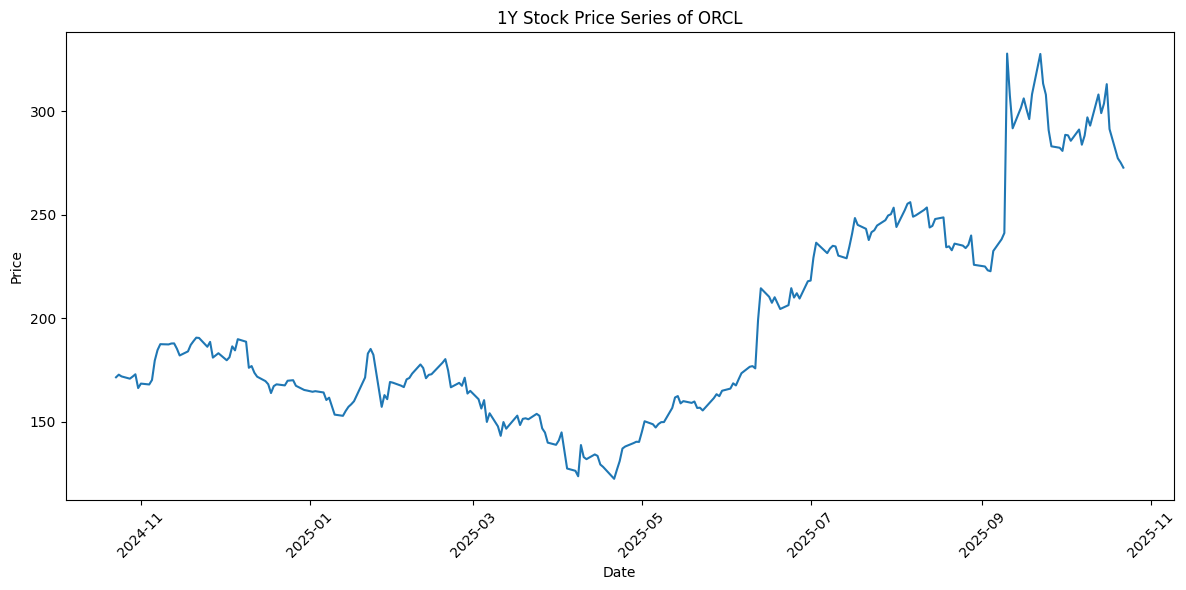

In [5]:
# Price series
for ticker in data_dict:
    df = data_dict[ticker]

    fig,ax = plt.subplots(figsize=(12,6))
    ax.plot(df.index, df['Close'])
    ax.set_title(f'1Y Stock Price Series of {ticker}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')

    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

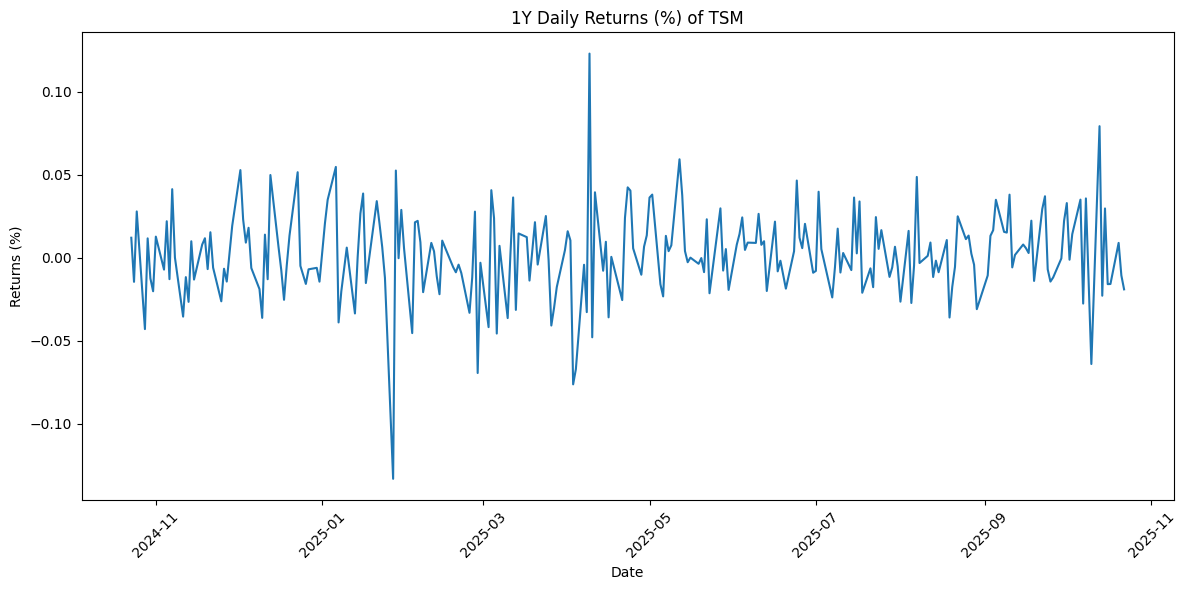

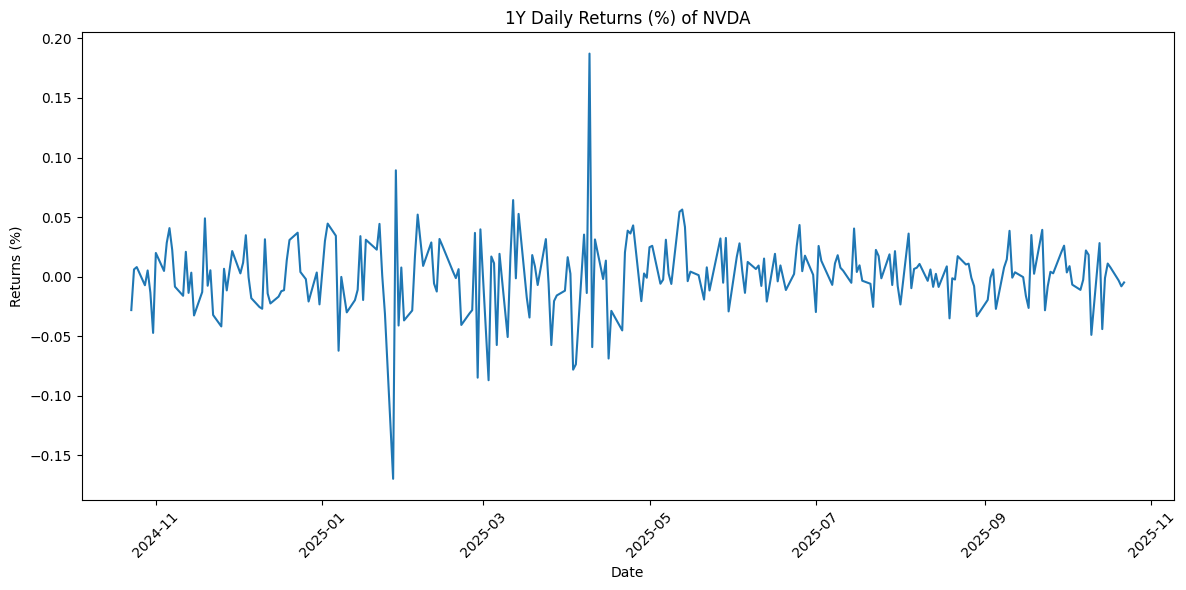

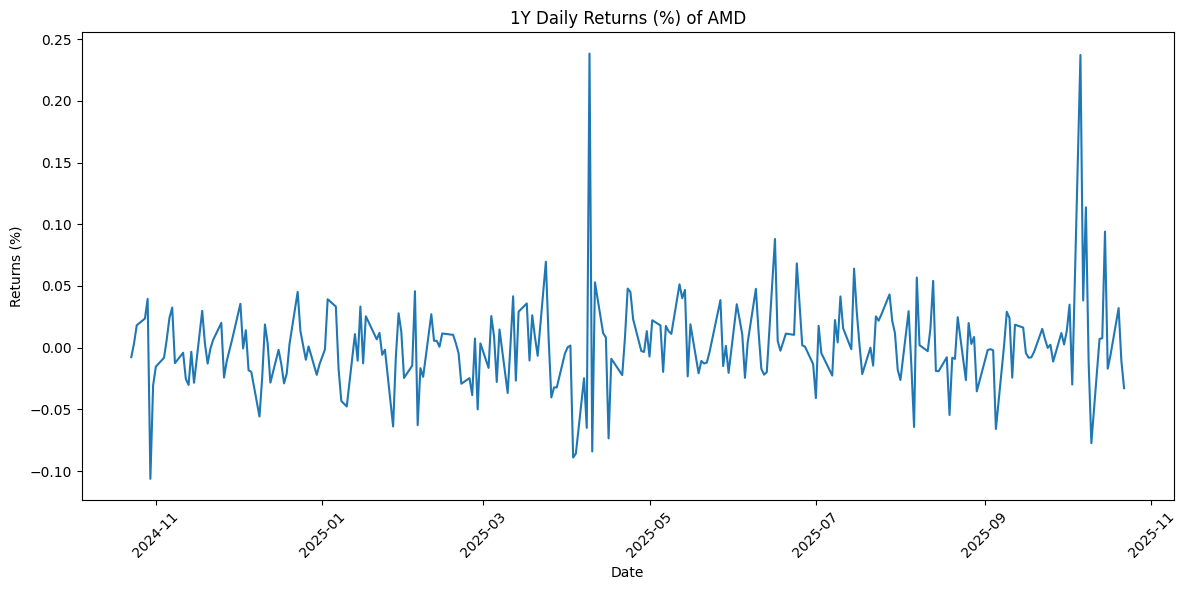

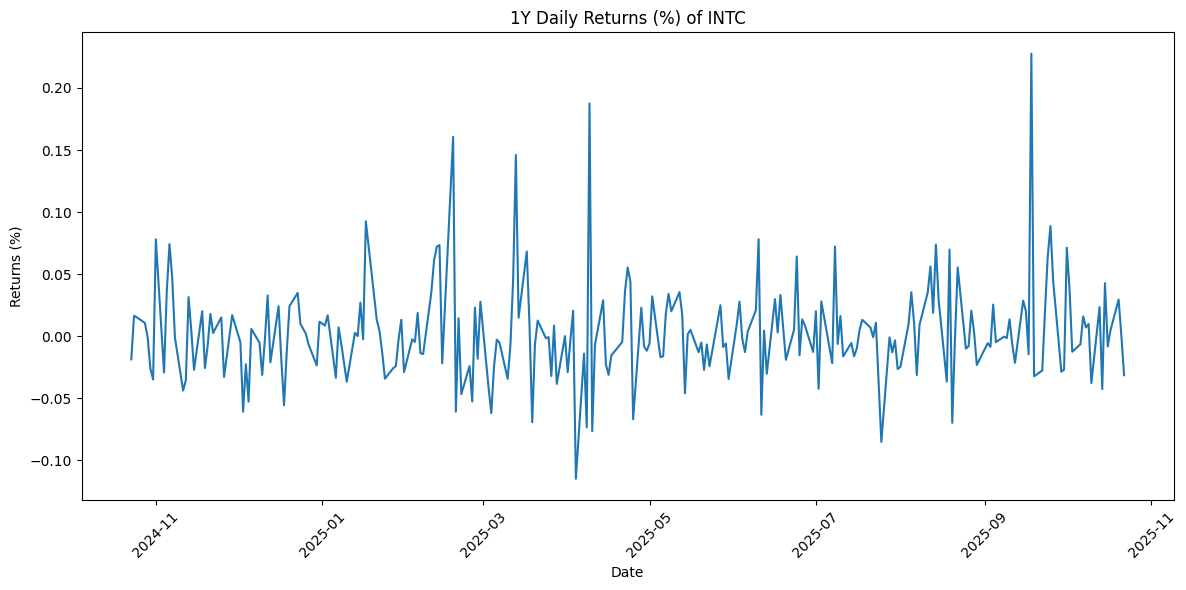

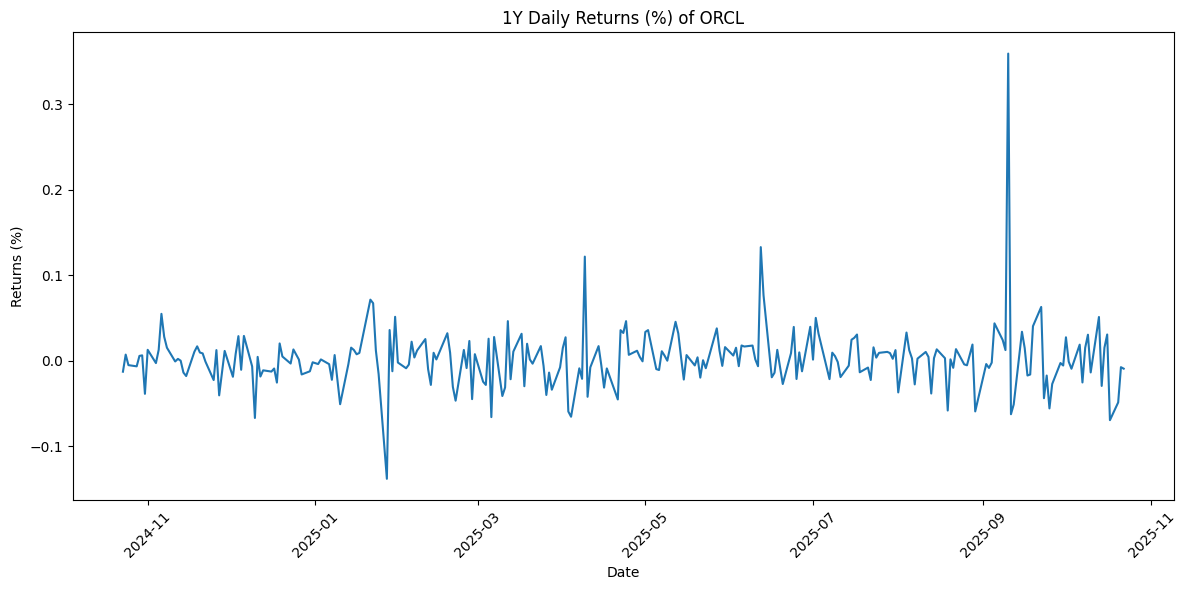

In [6]:
# Returns
for ticker in data_dict:
    df = data_dict[ticker]

    fig,ax = plt.subplots(figsize=(12,6))
    ax.plot(df.index, df['Daily_Return'])
    ax.set_title(f'1Y Daily Returns (%) of {ticker}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Returns (%)')

    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

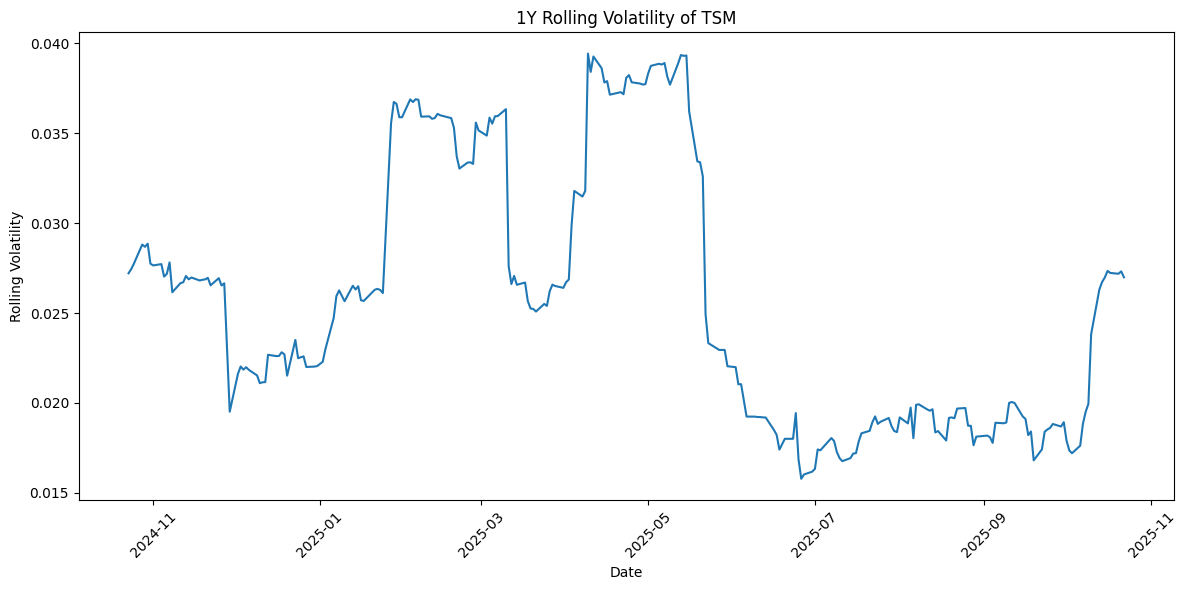

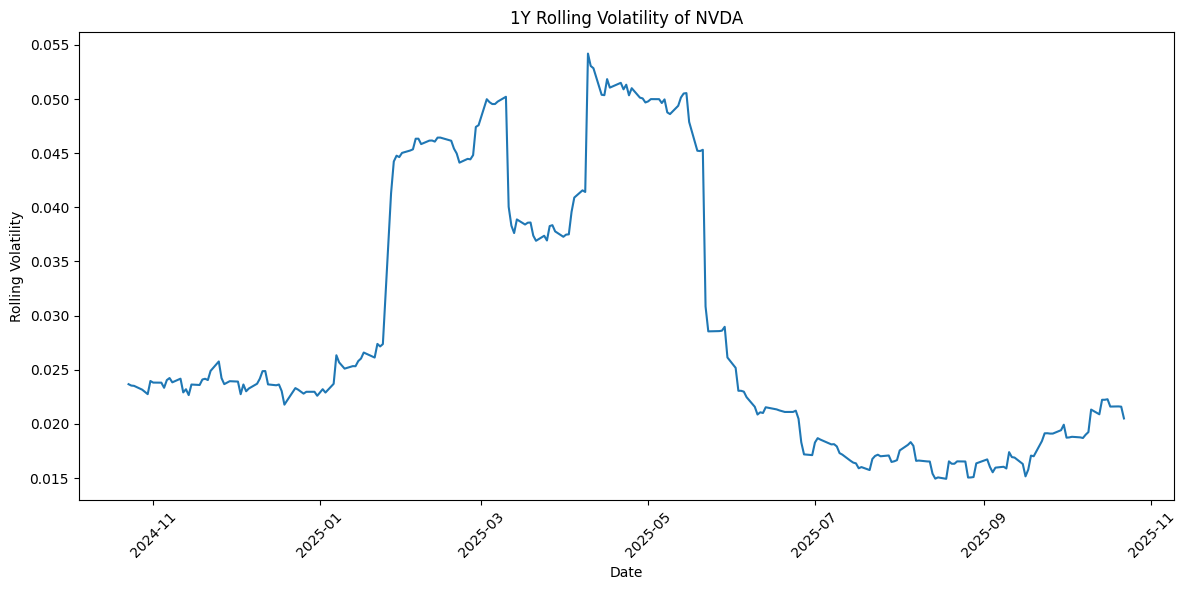

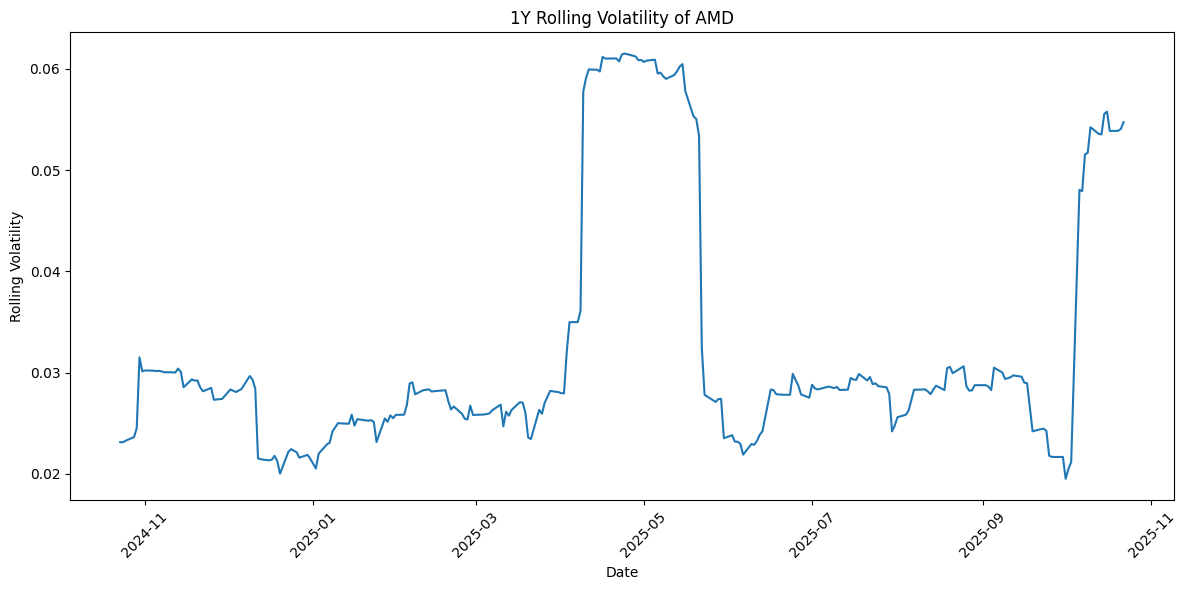

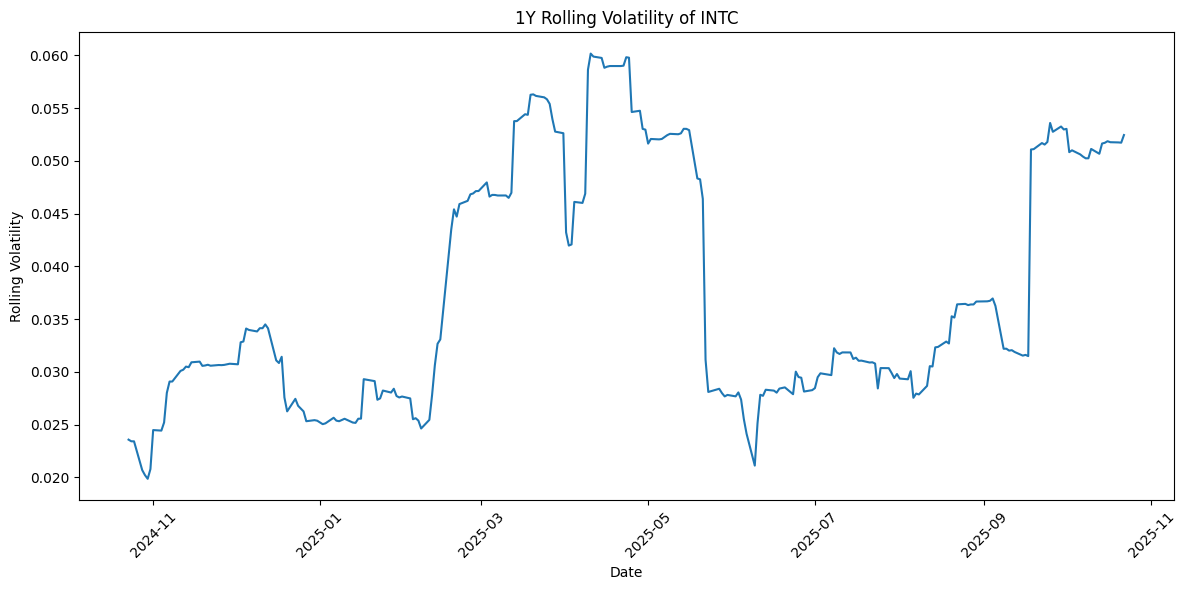

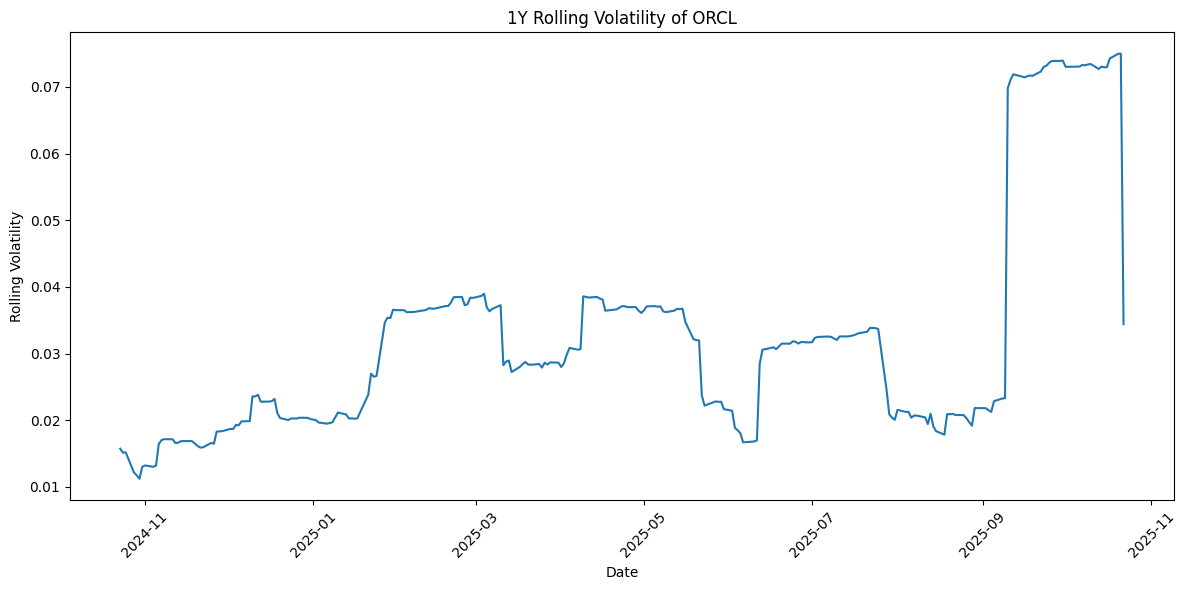

In [7]:
# Rolling
for ticker in data_dict:
    df = data_dict[ticker]

    fig,ax = plt.subplots(figsize=(12,6))
    ax.plot(df.index, df['Rolling_Vol'])
    ax.set_title(f'1Y Rolling Volatility of {ticker}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Rolling Volatility')

    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()


Correlation Matrix (Daily Returns):
        TSM   NVDA    AMD   INTC   ORCL
TSM   1.000  0.749  0.606  0.255  0.510
NVDA  0.749  1.000  0.571  0.338  0.545
AMD   0.606  0.571  1.000  0.326  0.326
INTC  0.255  0.338  0.326  1.000  0.203
ORCL  0.510  0.545  0.326  0.203  1.000


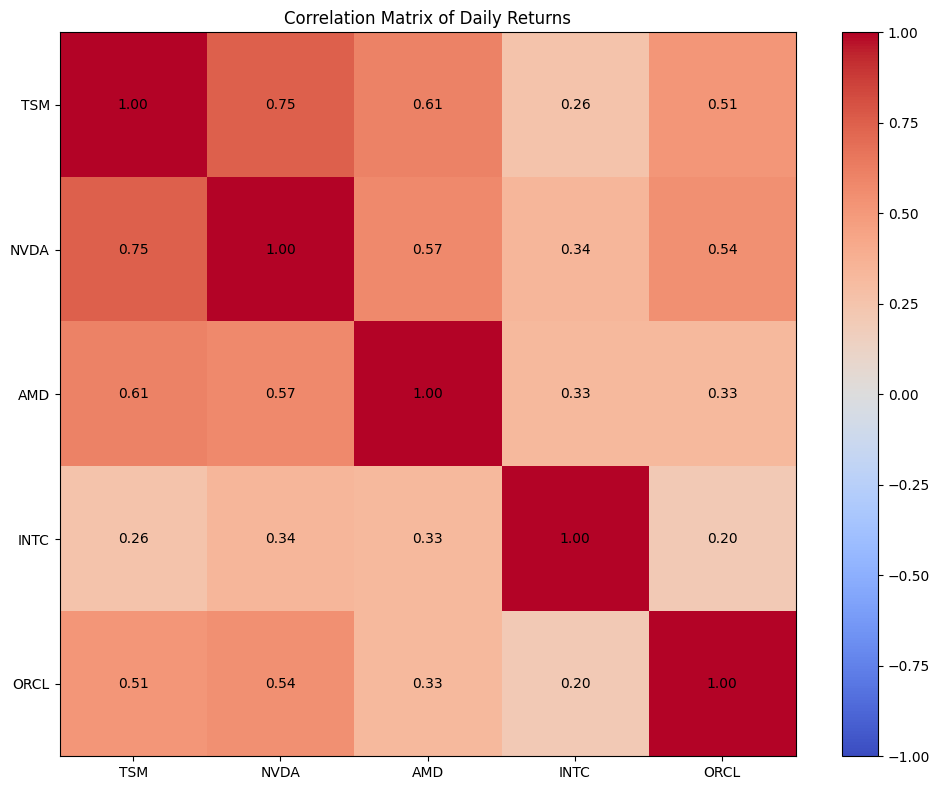

In [8]:
# Asset correlation
# df of all returns
returns_df = pd.DataFrame()
for ticker in data_dict:
    returns_df[ticker] = data_dict[ticker]['Daily_Return']

print("\nCorrelation Matrix (Daily Returns):")
print(returns_df.corr().round(3))

# matrix viz
fig, ax = plt.subplots(figsize=(10, 8))
correlation_matrix = returns_df.corr()
im = ax.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
ax.set_xticks(np.arange(len(tickers)))
ax.set_yticks(np.arange(len(tickers)))
ax.set_xticklabels(tickers)
ax.set_yticklabels(tickers)

# adding corr values to the plot
for i in range(len(tickers)):
    for j in range(len(tickers)):
        text = ax.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                       ha="center", va="center", color="black")

plt.colorbar(im, ax=ax)
ax.set_title('Correlation Matrix of Daily Returns')
plt.tight_layout()
plt.show()

#### The highest correlation (other than to itself) is between NVDA and TSMC. This is interesting to see and definitely makes sense when thinking of how they depend on eachother fundamentally as a business - using TSMC Foundry, Design, and Production to create NVDA chips - it would make sennse they trade together.


NVDA vs TSM:
  Beta: 0.875
  R-squared: 0.561


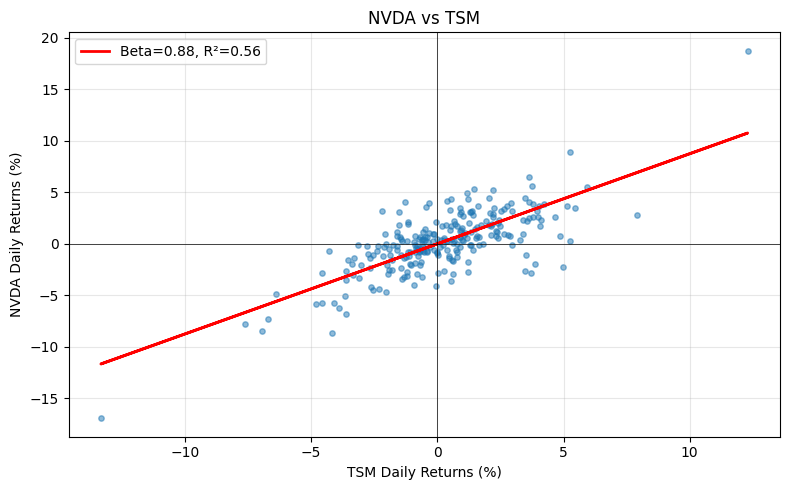


AMD vs TSM:
  Beta: 0.843
  R-squared: 0.367


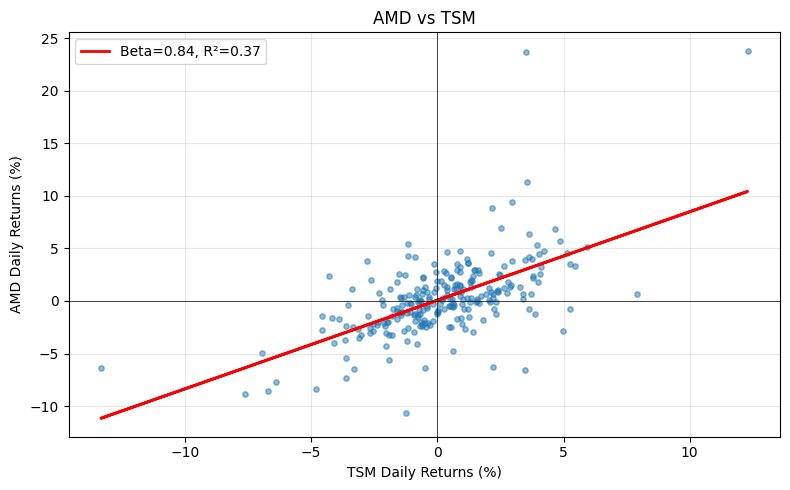


INTC vs TSM:
  Beta: 0.383
  R-squared: 0.065


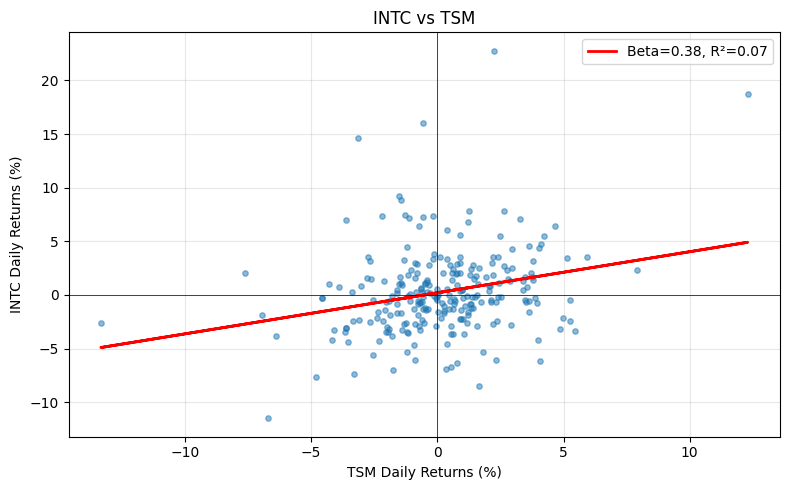


ORCL vs TSM:
  Beta: 0.712
  R-squared: 0.260


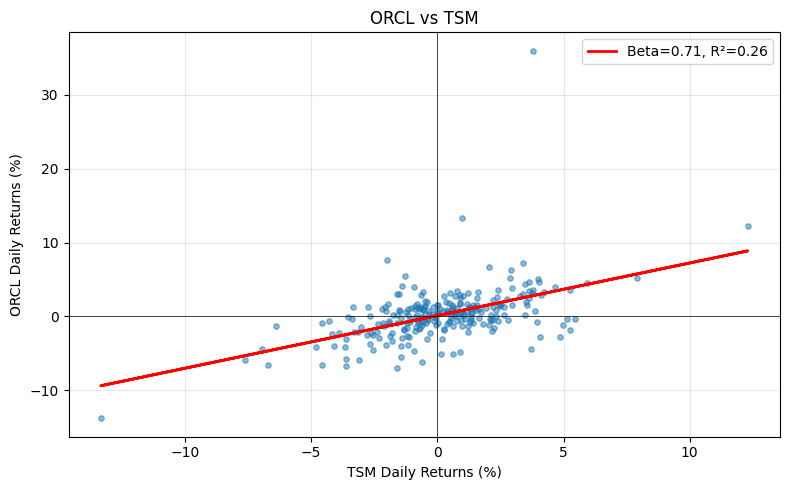


AMD vs NVDA:
  Beta: 0.680
  R-squared: 0.326


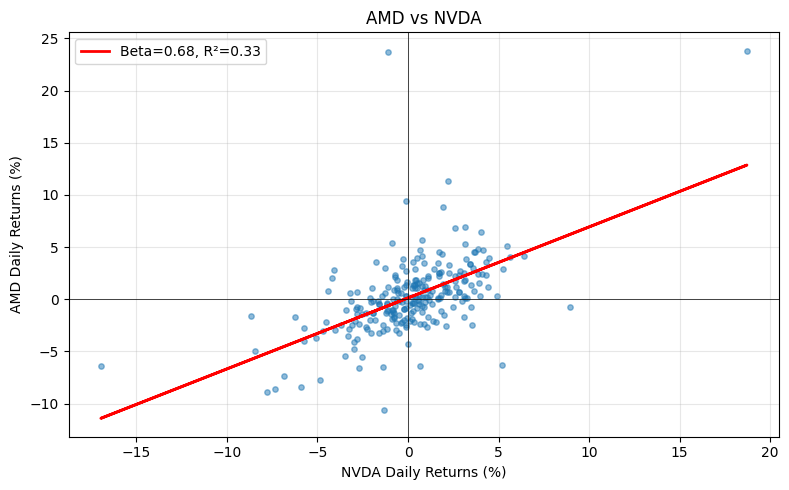


INTC vs NVDA:
  Beta: 0.434
  R-squared: 0.114


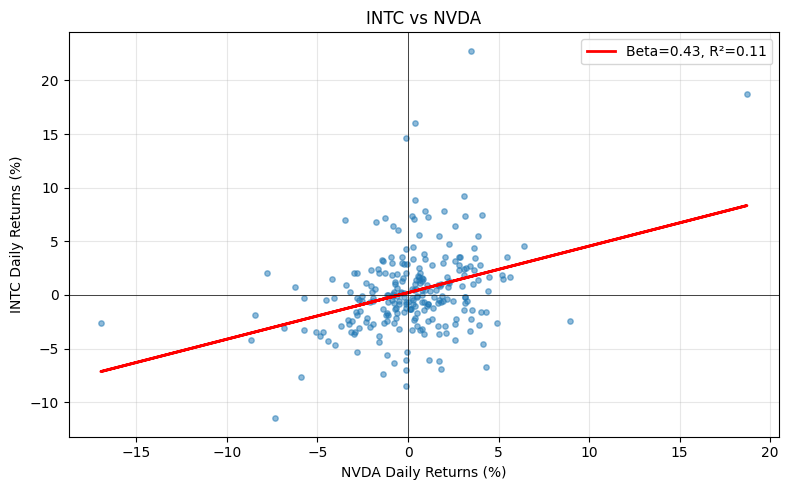


ORCL vs NVDA:
  Beta: 0.651
  R-squared: 0.297


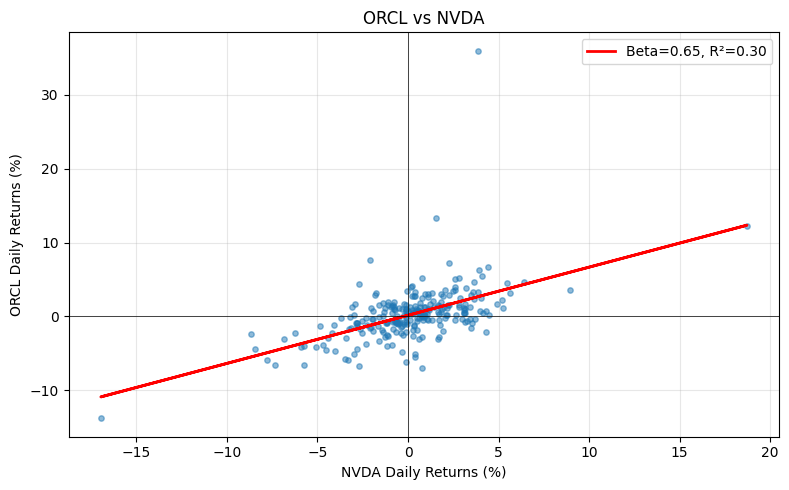


INTC vs AMD:
  Beta: 0.352
  R-squared: 0.106


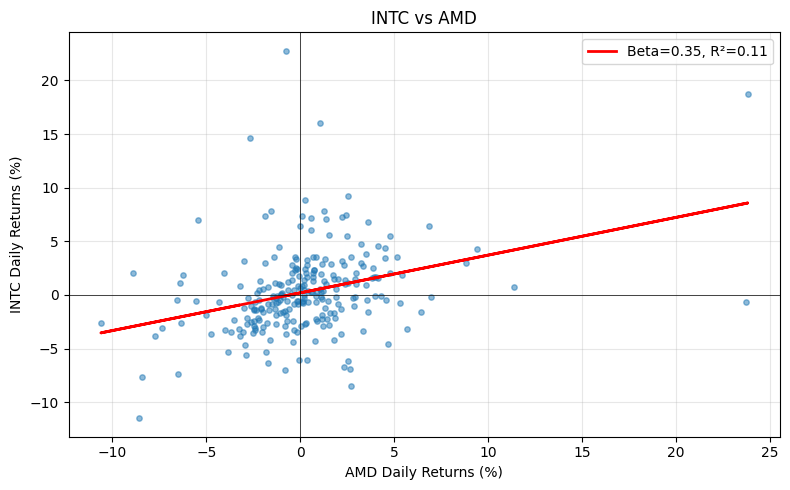


ORCL vs AMD:
  Beta: 0.327
  R-squared: 0.106


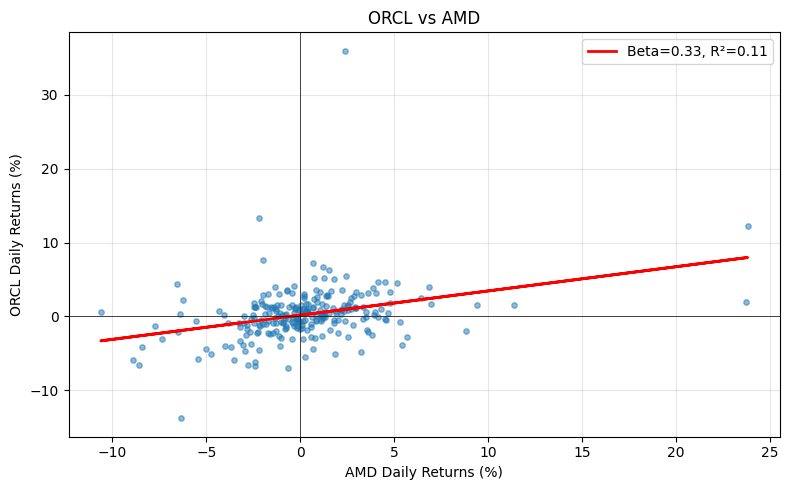


ORCL vs INTC:
  Beta: 0.189
  R-squared: 0.041


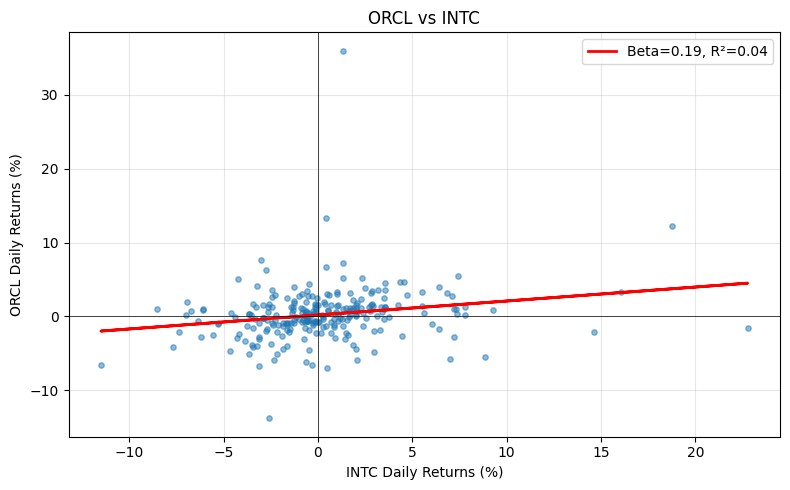

In [9]:
from scipy import stats

# more viz (lin regression)
for i, ticker1 in enumerate(tickers):
    for ticker2 in tickers[i + 1:]:


        returns1 = data_dict[ticker1]['Daily_Return'].dropna()
        returns2 = data_dict[ticker2]['Daily_Return'].dropna()
        common_dates = returns1.index.intersection(returns2.index)
        x = returns1.loc[common_dates].values
        y = returns2.loc[common_dates].values

        # Linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        line = slope * x + intercept

        # stats
        print(f"\n{ticker2} vs {ticker1}:")
        print(f"  Beta: {slope:.3f}")
        print(f"  R-squared: {r_value ** 2:.3f}")

        # scatter w/ regression line
        fig, ax = plt.subplots(figsize=(8, 5))
        ax.scatter(x * 100, y * 100, alpha=0.5, s=15)
        ax.plot(x * 100, line * 100, 'r-', linewidth=2,
                label=f'Beta={slope:.2f}, R²={r_value ** 2:.2f}')
        ax.set_xlabel(f'{ticker1} Daily Returns (%)')
        ax.set_ylabel(f'{ticker2} Daily Returns (%)')
        ax.set_title(f'{ticker2} vs {ticker1}')
        ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
        ax.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
        ax.legend()
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()